In [1]:
print ('Loading dependencies...', end = '')
try:
    import pandas as pd
    from tqdm import tqdm
    import numpy as np
    import os
    from Bio import SeqIO
    from Bio.SeqRecord import SeqRecord
    import sys
    from ete3 import NCBITaxa
    ncbi = NCBITaxa()
    print('Successful')
except:
    print('MISSING DEPENDENCIES!')

Loading dependencies...Successful


In [2]:
desired_ranks=['species','genus','family']
#Sourcing from BOLD https://v3.boldsystems.org/index.php/Public_SearchTerms?query=Magnoliophyta[tax] 
df=pd.read_table('bold_data.txt',encoding = "latin").rename(columns={'species_name':'species',
                'genus_name':'genus','family_name':'family'})
print(df.shape)
print(df.columns)
df[:2]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(361039, 46)
Index(['processid', 'sampleid', 'recordID', 'catalognum', 'fieldnum',
       'institution_storing', 'bin_uri', 'phylum_taxID', 'phylum_name',
       'class_taxID', 'class_name', 'order_taxID', 'order_name',
       'family_taxID', 'family', 'subfamily_taxID', 'subfamily_name',
       'genus_taxID', 'genus', 'species_taxID', 'species', 'subspecies_taxID',
       'subspecies_name', 'identification_provided_by', 'voucher_type',
       'tissue_type', 'collectors', 'collectiondate', 'lifestage', 'sex',
       'reproduction', 'extrainfo', 'notes', 'lat', 'lon', 'coord_source',
       'coord_accuracy', 'country', 'province', 'region', 'exactsite',
       'sequenceID', 'markercode', 'genbank_accession', 'nucleotides',
       'Unnamed: 45'],
      dtype='object')


,processid,sampleid,recordID,catalognum,fieldnum,institution_storing,bin_uri,phylum_taxID,phylum_name,class_taxID,...,coord_accuracy,country,province,region,exactsite,sequenceID,markercode,genbank_accession,nucleotides,Unnamed: 45
0,ALM011-11,BC-2011-36011,2096783,,1339-2005-A,"Universite de Montreal, L'Herbier Marie-Victorin",,12,Magnoliophyta,41,...,,Canada,Quebec,,,4168811,rbcLa,,GGTGTTGGATTCAAGGCTGGTGTTAAAGATTATAAATTGACTTATT...,NaN
1,ALM011-11,BC-2011-36011,2096783,,1339-2005-A,"Universite de Montreal, L'Herbier Marie-Victorin",,12,Magnoliophyta,41,...,,Canada,Quebec,,,4179363,matK,,---------------ATCCTTCGCTATTGGGTGAAAGATCCCTCCT...,NaN


In [3]:
df = df [['processid', 'sampleid', 'recordID', 'species', 'genus', 'family','sequenceID', 
           'markercode', 'nucleotides']]
df[:2]

,processid,sampleid,recordID,species,genus,family,sequenceID,markercode,nucleotides
0,ALM011-11,BC-2011-36011,2096783,,,,4168811,rbcLa,GGTGTTGGATTCAAGGCTGGTGTTAAAGATTATAAATTGACTTATT...
1,ALM011-11,BC-2011-36011,2096783,,,,4179363,matK,---------------ATCCTTCGCTATTGGGTGAAAGATCCCTCCT...


In [4]:
# Remove samples without species name
print(df.shape)
df = df[~df.species.isna()]
df = df[~ (df.species == ' ')]
print(df.shape)
# Remove samples without sequence
print(df.shape)
df = df[~df.nucleotides.isna()]
df = df[~ (df.nucleotides == ' ')]
print(df.shape)

(361039, 9)
(306966, 9)
(306966, 9)
(298701, 9)


In [5]:
df.groupby('markercode').size().sort_values(ascending=False)

markercode
matK           92297
ITS2           90243
rbcL           56559
rbcLa          39397
trnH-psbA       7949
ITS             3184
trnL-F          2236
ITS1            1636
rpoC1           1196
atpF-atpH       1120
rpoB             815
psbK-psbI        731
COI-5P           694
ycf1             137
atpB-rbcL         94
trnK              72
matR              61
petD-intron       48
matK-trnK         48
COXIII            47
atp6              46
COII              46
matK-like         26
rbcL-like         19
dtype: int64

In [6]:
df.groupby('markercode').size().sort_values(ascending=False)[:4]

markercode
matK     92297
ITS2     90243
rbcL     56559
rbcLa    39397
dtype: int64

In [7]:
markers=['matK', 'rbcL','rbcLa']

In [9]:
bold_df=df[df.markercode.isin(markers)]
bold_df['length']=bold_df.nucleotides.str.replace('-', '').str.len()
bold_df = bold_df.rename(columns={'sequenceID':'SeqID'})
print(bold_df.shape)
bold_df[:2]

(188253, 10)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,processid,sampleid,recordID,species,genus,family,sequenceID,markercode,nucleotides,length
4,ALM033-11,BC-2011-36033,2096805,Salix nigra,Salix,Salicaceae,4179266,matK,GAAAAATTGGTTCAAATCCTTCGCTATTGGGTGAAAGATCCCTCCT...,824
5,ALM033-11,BC-2011-36033,2096805,Salix nigra,Salix,Salicaceae,4168959,rbcLa,GGTGTTGGATTCAAGGCTGGTGTTAAAGATTATAAATTGACTTATT...,552


In [10]:
bold_df.isna().sum()

processid      0
sampleid       0
recordID       0
species        0
genus          0
family         0
sequenceID     0
markercode     0
nucleotides    0
length         0
dtype: int64

In [11]:
bold_df.nunique()

processid      157261
sampleid       157259
recordID       157261
species         55433
genus            9961
family            424
sequenceID     188253
markercode          3
nucleotides    129048
length           1628
dtype: int64

## Save to fasta

In [25]:
def writefasta(sample_name, df_sample):
    file1 = open(sample_name + '_raw.fasta',"w")
    for index, iseq in tqdm(df_sample.iterrows()):
        try:
            file1.write('>' + str(iseq.SeqID) + ' sci_name=' + iseq.species + ', sampleid=' + 
                        str(iseq.sampleid) + ', length=' + str(len(iseq.nucleotides)) + '\n') 
            
            #Sequences are aligned, choice to removed alignment information
            file1.write(iseq.nucleotides.replace('-', '') + '\n') 
        except:
            print('failed writing ' + str(iseq.SeqID) + ', species_name=' + iseq.species)
    file1.close()

In [26]:
for imarker in markers:
    bold_marker=bold_df[bold_df.markercode==imarker]
    print(bold_marker.shape)
    bold_marker=bold_marker.drop_duplicates(subset='SeqID')
    print(bold_marker.shape)
    writefasta(sample_name = 'BOLD_pln_' + imarker, df_sample = bold_marker)
    bold_marker.drop(columns=['nucleotides','markercode']).to_csv('BOLD_pln_' + imarker + '_raw_SeqID.csv', index=False)

373it [00:00, 3266.29it/s]

(92297, 10)
(92297, 10)


92297it [00:18, 4893.94it/s]
355it [00:00, 3415.66it/s]

(56559, 10)
(56559, 10)


56559it [00:10, 5552.79it/s]
442it [00:00, 3980.18it/s]

(39397, 10)
(39397, 10)


39397it [00:06, 5951.14it/s]


0.01     420.0
0.05     510.0
0.10     527.0
0.50     552.0
0.90     568.0
0.95     706.0
0.99    1455.0
Name: length, dtype: float64


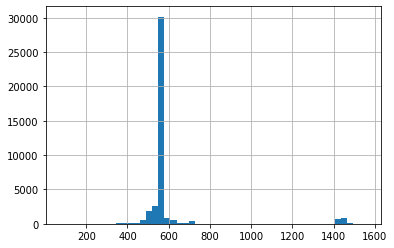

In [24]:
bold_marker=bold_df[bold_df.markercode=='rbcLa']
print(bold_marker.length.quantile([0.01, 0.05, .1, .5, 0.9, 0.95, 0.99]))
bold_marker.length.hist(bins=50)

0.01     423.0
0.05     505.0
0.10     531.0
0.50     697.0
0.90    1389.0
0.95    1389.0
0.99    1425.0
Name: length, dtype: float64


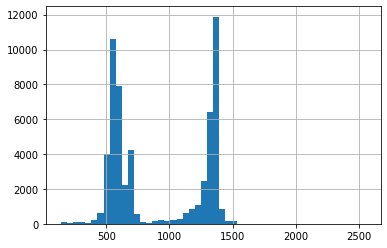

In [23]:
bold_marker=bold_df[bold_df.markercode=='rbcL']
print(bold_marker.length.quantile([0.01, 0.05, .1, .5, 0.9, 0.95, 0.99]))
bold_marker.length.hist(bins=50)

0.01     330.00
0.05     510.00
0.10     632.00
0.50     819.00
0.90    1531.00
0.95    1545.00
0.99    1567.04
Name: length, dtype: float64


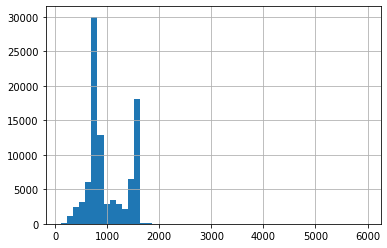

In [22]:
bold_marker=bold_df[bold_df.markercode=='matK']
print(bold_marker.length.quantile([0.01, 0.05, .1, .5, 0.9, 0.95, 0.99]))
bold_marker.length.hist(bins=50)